In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Concatenate, Softmax
import time
import pandas as pd
import os
import tqdm
import gensim.downloader
from sklearn.model_selection import train_test_split

In [2]:
def load_dataset(shard_ids):
    path = 'wikisum-en/nl2sl/web-only_v3/'
    x_files = []
    y_files = []
    title_files = []
    for shard_id in shard_ids:
        x_files.append("{}inputs.txt-{:05d}-of-01000".format(path, shard_id))
        y_files.append("{}outputs.txt-{:05d}-of-01000".format(path, shard_id))
        title_files.append("{}titles.txt-{:05d}-of-01000".format(path, shard_id))
    x = []
    y = []
    titles = []
    for i in range(len(x_files)):
        with open(x_files[i], 'r') as x_file:
            for line in x_file:
                x.append(line)
        with open(y_files[i], 'r') as y_file:
            for line in y_file:
                y.append(line)
        with open(title_files[i], 'r') as title_file:
            for line in title_file:
                titles.append(line)
    return x[:-1], y[:-1], titles[:-1]


dataset_shard_ids = [0]# i for i in range(45)]#0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]#, 1, 2, 3, 4, 5]
#val_shard_ids = [18, 19, 20]
natural_language_data, structured_langague_data, titles = load_dataset(dataset_shard_ids)

#x_val, y_val = load_dataset(val_shard_ids)


In [3]:
def limit_dataset(x, y, titles, max_words_per_statement):
    out_x = []
    out_y = []
    out_titles = []
    for i in range(len(x)):
        n_statements = len(y[i].split()) - 2
        n_tokens = len(x[i].split()) - 2
        n_title = len(titles[i].split())
        if(n_tokens + n_title <= 300 and n_statements <= 300):
            if float(n_tokens)/n_statements < max_words_per_statement:
                out_x.append(x[i].replace("\n", "").replace("\r", "").lower())
                out_y.append(y[i].replace("\n", "").replace("\r", "").lower())
                out_titles.append(titles[i].replace("\n", "").replace("\r", "").lower())
    return out_x, out_y, out_titles

limited_natural_language_data, limited_structured_langague_data, limited_titles = limit_dataset(natural_language_data, structured_langague_data, titles, 5)
print(len(limited_natural_language_data))
for i in range(20):
    print("{} {} -> {}".format(limited_titles[i], limited_natural_language_data[i], limited_structured_langague_data[i]))


7608
tyler haskins [ini-nl] tyler haskins statistics on statscrew . com [end-nl] -> [ini-sl] familyname haskins [end-sl]
tyler haskins [ini-nl] tyler haskins born may 26 , 1986 is an american professional ice hockey forward currently playing as captain of the grizzlys wolfsburg in the deutsche eishockey liga del . he was selected by the detroit red wings in the 5th round 162nd overall of the 2004 nhl entry draft . [end-nl] -> [ini-sl] familyname haskins dateofbirth 1986 / 05 / 26 sport ice hockey draftedby detroit red wings [end-sl]
tyler haskins [ini-nl] check out tyler haskins profile on the official del website . [end-nl] -> [ini-sl] givenname tyler familyname haskins [end-sl]
tyler haskins [ini-nl] tyler haskins stats and news nhl . com [end-nl] -> [ini-sl] familyname haskins [end-sl]
muawiyah i [ini-nl] mu awiya is the kisra of the arabs . [end-nl] -> [ini-sl] ethnicgroup arabs [end-sl]
muawiyah i [ini-nl] sign up to al islam . org [end-nl] -> [ini-sl] religion islam [end-sl]
muaw

Distribuição de tokens na entrada


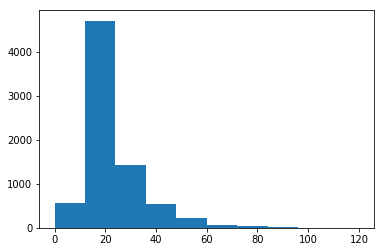

Distribuição de tokens na saida


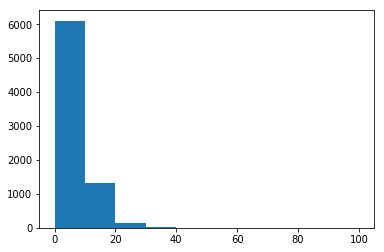

Distribuição de tokens na entrada/statements na saida


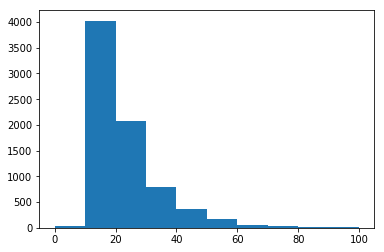

In [4]:
def show_distributions(x, y):
    # Distribuicao do numero de palavras nas avaliacoes e titulos
    print("Distribuição de tokens na entrada")
    plt.hist([len(linha.split()) for linha in x], range=(0, 120))
    plt.show()
    print("Distribuição de tokens na saida")
    plt.hist([len(linha.split()) for linha in y], range=(0, 100))
    plt.show()
    print("Distribuição de tokens na entrada/statements na saida")
    statements = [len(linha.split("SEP")) for linha in y]
    tokens = [len(linha.split()) for linha in x]
    plt.hist([float(tokens[i])/statements[i] for i in range(len(x))], range=(0, 100))
    plt.show()

def joint_texts(a, b):
    out = []
    for i in range(len(a)):
        out.append(a[i]+ ' ' + b[i])
    return out

#show_distributions(natural_language_data, structured_langague_data)
x = joint_texts(limited_titles, limited_natural_language_data)
y = limited_structured_langague_data
show_distributions(x, y)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42, stratify=None)


In [5]:
def generate_vocab(sentences):
    vocab = {}
    index = 0
    for sentence in sentences:
        for word in sentence.split(' '):
            if(word not in vocab):
                vocab[word] = index
                index = index + 1
    return vocab

#vocab_dict = generate_vocab(x_train+y_train+x_val+y_val)
vocab_dict = generate_vocab(x_train+y_train)
vocab = [word for word in vocab_dict]
print(len(vocab))

15352


In [6]:
def create_tokenizers(vocab_size, max_input_size, max_output_size, words):
    # camada de tokenização
    input_vectorize_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=max_input_size, standardize=None)
    output_vectorize_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=max_output_size, standardize=None)
    # adapta tokenizador com entrada + saida + [MASC] (saida já tem <SOS> e <EOS>)
    input_vectorize_layer.adapt(words)
    output_vectorize_layer.adapt(words)
    vocab = input_vectorize_layer.get_vocabulary()
    word_index = dict(zip(vocab, range(len(vocab))))
    return input_vectorize_layer, output_vectorize_layer, vocab, word_index

VOCAB_SIZE = len(vocab)
MAXTOKENS_SL = 50# max([len(line.split()) for line in x_train]) # 200 # tamanho maximo considerado para textos
MAXTOKENS_NL = 100# max([len(line.split()) for line in y_train]) # 50
print(MAXTOKENS_NL, MAXTOKENS_SL)
input_tokenizer_layer, output_tokenizer_layer, tokenizer_vocab, word_index = create_tokenizers(VOCAB_SIZE, MAXTOKENS_NL, MAXTOKENS_SL, vocab)

# tokenizando dados de treino e validacao
input_tokenizer_model = tf.keras.models.Sequential()
input_tokenizer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
input_tokenizer_model.add(input_tokenizer_layer)

output_tokenizer_model = tf.keras.models.Sequential()
output_tokenizer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
output_tokenizer_model.add(output_tokenizer_layer)
'''
t_x_train = input_tokenizer_model.predict(x_train_limited)
t_x_val = input_tokenizer_model.predict(x_val_limited)
t_y_train = output_tokenizer_model.predict(y_train_limited)
t_y_val = output_tokenizer_model.predict(y_val_limited)
print(x_train_limited[0], '-->', t_x_train[0])
print(y_train_limited[0], '-->', t_y_train[0])
'''
t_x_train = input_tokenizer_model.predict(x_train)
t_x_val = input_tokenizer_model.predict(x_val)
t_y_train = output_tokenizer_model.predict(y_train)
t_y_val = output_tokenizer_model.predict(y_val)
print(x_train[0], '-->', t_x_train[0])
print(y_train[0], '-->', t_y_train[0])



100 50
todd redmond [ini-nl] toronto blue jays designated rhp todd redmond for assignment . [end-nl] --> [ 1373  3736 14259  1334 12761  7611 10791  3447  1373  3736  9409 13418
 15210 14261     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[ini-sl] memberofsportsteam blue jays givenname todd [end-sl] --> [14258  6166 12761  7611  9004  1373 14260     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0


In [42]:
# criando dataset do tipo tf.dataset (ja separado em batchs)]
BUFFER_SIZE_TRAIN = len(t_x_train)
BUFFER_SIZE_VAL = len(t_x_val)
BATCH_SIZE = 16
steps_per_epoch_train = len(t_x_train)//BATCH_SIZE
steps_per_epoch_val = len(t_x_val)//BATCH_SIZE
dataset_train = tf.data.Dataset.from_tensor_slices((t_x_train, t_y_train)).shuffle(BUFFER_SIZE_TRAIN)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
# dataset de validacao
dataset_val = tf.data.Dataset.from_tensor_slices((t_x_val, t_y_val)).shuffle(BUFFER_SIZE_VAL)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset_train))
print(example_input_batch.shape, example_target_batch.shape)
'''
BUFFER_SIZE = len(x_train)
BATCH_SIZE = 32
steps_per_epoch_train = len(x_train)//BATCH_SIZE
steps_per_epoch_val = len(x_val)//BATCH_SIZE
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
# dataset de validacao
dataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset_train))
print(example_input_batch.shape, example_target_batch.shape)

print(example_input_batch[0])
'''

(16, 100) (16, 50)


'\nBUFFER_SIZE = len(x_train)\nBATCH_SIZE = 32\nsteps_per_epoch_train = len(x_train)//BATCH_SIZE\nsteps_per_epoch_val = len(x_val)//BATCH_SIZE\ndataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)\ndataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)\n# dataset de validacao\ndataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(BUFFER_SIZE)\ndataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)\n\nexample_input_batch, example_target_batch = next(iter(dataset_train))\nprint(example_input_batch.shape, example_target_batch.shape)\n\nprint(example_input_batch[0])\n'

In [42]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [43]:
def create_embedding(word_index, pretrained_embedding, vocab_size, embedding_dim, max_sentence_size):
    hits = 0
    misses = 0
    # epecial tokens embeddings
    especial_tokens_emb = {}
    i = -2
    for especial_token in ['[SEP]','[END-NL]', '[INI-NL]', '[INI-SL]', '[END-SL]']:
        especial_tokens_emb[especial_token] = [float(i) for k in range(embedding_dim)]
        i = i + 1
    print(especial_tokens_emb)
    # Preparando embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    j = 0
    for word, i in word_index.items():
        if(word in pretrained_embedding):
            embedding_matrix[i] = pretrained_embedding[word]
            hits += 1
        elif word in ['[SEP]','[END-NL]', '[INI-NL]', '[INI-SL]', '[END-SL]']: # criando embedding padrao para tokens especiais
            embedding_matrix[i] = especial_tokens_emb[word]
            j = j + 1
            hits += 1
        else:
            misses += 1
    print("Hits: {}, misses: {}".format(hits, misses))
    print('Palavras {} convertidas ({} perdidas, {}%)'.format(hits, misses, round(100*misses/(hits+misses), 1)))
    print('Dims da matriz de embeddings: {}'.format(embedding_matrix.shape))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sentence_size, weights=[embedding_matrix], trainable=False)
    return embedding_layer, embedding_matrix

# camada de embedding
EMBEDDING_DIM = 100
embedding_layer, embedding_matrix = create_embedding(word_index, glove_vectors, VOCAB_SIZE, EMBEDDING_DIM, MAXTOKENS_NL)
print('Embedding de [SEP]', embedding_matrix[word_index['[SEP]']])# embeddings definidos para tokens especiais
print('Embedding de good: ', embedding_matrix[word_index['good']])# embeddings para tokens de algumas palavras


{'[SEP]': [-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0], '[END-NL]': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.

In [8]:
EMBEDDING_DIM = 50
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAXTOKENS_NL, trainable=True)

In [9]:
class BiLSTMEncoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_layer, enc_units, batch_sz):
        super(BiLSTMEncoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = embedding_layer
        self.bilstm = Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(self.enc_units),
                                        return_sequences=True,
                                        return_state=True))

    def call(self, x, hidden):
        x = self.embedding(x)
        output, forward_h, forward_c, backward_h, backward_c =  self.bilstm(x, initial_state = hidden)
        return output, forward_h, forward_c, backward_h, backward_c

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(4)]
# encoder
units = 64
encoder = BiLSTMEncoder(VOCAB_SIZE, embedding_layer, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, forward_h, forward_c, backward_h, backward_c = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder forward_h shape: (batch size, units) {}'.format(forward_h.shape))
print('Encoder forward_c shape: (batch size, units) {}'.format(forward_c.shape))
print('Encoder backward_h shape: (batch size, units) {}'.format(backward_h.shape))
print('Encoder backward_c shape: (batch size, units) {}'.format(backward_c.shape))
forward_backward_h = Concatenate(axis=1)([forward_h, backward_h])
print(forward_backward_h.shape)




Encoder output shape: (batch size, sequence length, units) (16, 100, 128)
Encoder forward_h shape: (batch size, units) (16, 64)
Encoder forward_c shape: (batch size, units) (16, 64)
Encoder backward_h shape: (batch size, units) (16, 64)
Encoder backward_c shape: (batch size, units) (16, 64)
(16, 128)


In [10]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# camada de atencao
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(forward_backward_h, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


Attention result shape: (batch size, units) (16, 128)
Attention weights shape: (batch_size, sequence_length, 1) (16, 100, 1)


tf.Tensor(
[b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]'
 b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]'
 b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]'
 b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]'
 b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]' b'[INI-SL]'
 b'[INI-SL]' b'[INI-SL]'], shape=(32,), dtype=string)


InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [32,1,256] vs. shape[1] = [32,50,100] [Op:ConcatV2] name: concat

In [53]:
class PGDecoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_layer, dec_units, batch_sz, vocab):
        super(PGDecoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = embedding_layer
        self.gru = tf.keras.layers.RNN(tf.keras.layers.GRUCell(self.dec_units),
                                        return_sequences=True,
                                        return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        # used for attention
        self.attention = BahdanauAttention(self.dec_units)
        # p gen layer
        self.p_gen_layer = tf.keras.layers.Dense(1, activation='sigmoid')
        self.vocab = vocab
        self.n_vocab = len(self.vocab)
        self.indexes = []
        self.n_extended_vocab = self.n_vocab
        self.batch_extended_vocab = self.vocab.copy()

    def call(self, x, hidden, enc_output, batch_input_words):
        #self.indexes = self.extend_vocab(batch_input_words)
        #print(indexes)
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        #print(attention_weights.shape)
        #print(context_vector.shape)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        #print(x.shape)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # generating probability
        # pgen input size == (batch_size, 1, state_size + embedding_dim + hidden_size)
        pgen = self.p_gen_layer(tf.concat([tf.expand_dims(state, 1), x], axis=-1))
        #print(pgen.shape)
        pgen = tf.reshape(pgen, (-1, pgen.shape[2]))
        #print(pgen.shape, pgen[0].numpy())
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size, vocab)
        x = self.fc(output)
        #print(x.shape)
        x = tf.math.multiply(pgen, x)
        #print(x.shape)
        # extend x to extended vocab
        x = tf.concat([x,tf.zeros([self.batch_sz, self.n_extended_vocab - self.n_vocab])], 1)
        #print(x.shape)
        #print(x[0][2].numpy(), x[0][15365].numpy())
        #print(self.tokenized_batch_input_extended_vocab[12][:].numpy(), batch_input_words[12])
        attention_sum = tf.zeros([self.batch_sz, self.n_extended_vocab])
        for i in self.indexes:
            #print(tf.where(tf.math.equal(self.tokenized_batch_input_extended_vocab, i)))
            for pos in tf.where(tf.math.equal(self.tokenized_batch_input_extended_vocab, i)):
                #print(pos)
                attention_sum[pos[0]][i] = attention_sum[pos[0]][i] + (1 - pgen[pos[0]]) * attention_weights[pos[0]][pos[1]][0]
        #print(x.shape, attention_sum.shape)
        #print(attention_sum[12][15363], attention_sum[12][37])
        x = x + tf.convert_to_tensor(attention_sum, dtype=tf.dtypes.float32)
        return x, state, attention_weights, self.batch_extended_vocab

    def split_batch_input(self, max_tokens, batch):
        out = []
        for x in batch:
            #print(x)
            x_list = x.split()[:max_tokens]
            out.append(x_list)
        return out

    def tokenize_and_pad_with_extended_vocab(self, extended_vocab, batch_words, max_tokens):
        to_out = []
        indexes = []
        for word_list in batch_words:
            token_list = []
            for word in word_list:
                token_list.append(extended_vocab[word])
                if(extended_vocab[word] not in indexes):
                    indexes.append(extended_vocab[word])
            size = len(token_list)
            if(size < max_tokens):
                for i in range(max_tokens - size):
                    token_list.append(0)
            to_out.append(token_list)
        return tf.convert_to_tensor(to_out), indexes

    def extend_vocab(self, batch_input_sentences, batch_output_sentences):
        batch_input_words = self.split_batch_input(MAXTOKENS_NL, batch_input_sentences)
        self.batch_extended_vocab = self.vocab.copy()
        i = self.n_vocab
        for j in range(len(batch_input_words)):
            for word in batch_input_words[j]:
                if(word not in self.batch_extended_vocab):
                    self.batch_extended_vocab[word] = i
                    i = i + 1
        self.n_extended_vocab = len(self.batch_extended_vocab)
        self.tokenized_batch_input_extended_vocab, self.indexes = self.tokenize_and_pad_with_extended_vocab(self.batch_extended_vocab, batch_input_words, MAXTOKENS_NL)
        batch_output_words = self.split_batch_input(MAXTOKENS_SL, batch_output_sentences)
        tokenized_batch_output_extended_vocab, _ = self.tokenize_and_pad_with_extended_vocab(self.batch_extended_vocab, batch_output_words, MAXTOKENS_SL)
        return tokenized_batch_output_extended_vocab

# decoder
a = 12
example_input_batch = x_val[a:a+BATCH_SIZE]
decoder = PGDecoder(VOCAB_SIZE, embedding_layer, 2*units, BATCH_SIZE, vocab_dict)
sample_decoder_output, _, _, extended_vocab = decoder(tf.random.uniform((BATCH_SIZE, 1)), forward_backward_h, sample_output, example_input_batch)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


Decoder output shape: (batch_size, vocab size) (16, 15352)


In [54]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    mask2 = tf.cast(mask, dtype=tf.int32)
    predicted_ids = tf.argmax(pred, axis=1)
    matches = tf.cast(tf.math.equal(real, predicted_ids), dtype=tf.int32)
    matches *= mask2
    return tf.reduce_mean(loss_), tf.reduce_sum(matches)

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [56]:
@tf.function
def train_step(inp, targ, enc_hidden, inp_txt, targ_txt):
    loss = 0
    matches = 0
    with tf.GradientTape() as tape:
        enc_output, enc_forward_h, enc_forward_c, enc_backward_h, enc_backward_c = encoder(inp, enc_hidden)
        dec_hidden = Concatenate(axis=1)([enc_forward_h, enc_backward_h])
        dec_input = tf.expand_dims([word_index['[ini-sl]']] * BATCH_SIZE, 1)
        #print(dec_input.shape, dec_hidden.shape)
        # Teacher forcing - feeding the target as the next input
        #print(targ.shape[1])
        extended_targ = decoder.extend_vocab(inp_txt, targ_txt)
        for t in range(1, extended_targ.shape[1]):
            #print(dec_hidden.shape)
            # passing enc_output to the decoder
            predictions, dec_hidden, _, _ = decoder(dec_input, dec_hidden, enc_output, inp_txt)
            new_loss, new_matches = loss_function(extended_targ[:, t], predictions)
            loss += new_loss
            matches += new_matches
            #print(tf.cast(tf.math.equal(targ[:, t], predicted_ids), dtype=tf.int32))
            #print(matches)
            # using teacher forcing
            dec_input = tf.expand_dims(extended_targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss, matches

@tf.function
def validation_step(inp, targ, enc_hidden, inp_txt, targ_txt):
    loss = 0
    enc_output, enc_forward_h, enc_forward_c, enc_backward_h, enc_backward_c = encoder(inp, enc_hidden)
    dec_hidden = Concatenate(axis=1)([enc_forward_h, enc_backward_h])
    dec_input = tf.expand_dims([word_index['[ini-sl]']] * BATCH_SIZE, 1)
    matches = 0
    #print(dec_input.shape, dec_hidden.shape)
    extended_targ = decoder.extend_vocab(inp_txt, targ_txt)
    # Teacher forcing - feeding the target as the next input
    for t in range(1, extended_targ.shape[1]):
        #print(dec_hidden.shape)
        # passing enc_output to the decoder
        predictions, dec_hidden, _, _ = decoder(dec_input, dec_hidden, enc_output, inp_txt)
        new_loss, new_matches = loss_function(extended_targ[:, t], predictions)
        loss += new_loss
        matches += new_matches
        # using teacher forcing
        dec_input = tf.expand_dims(extended_targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    return batch_loss, matches

In [57]:
N_WORDS_IN_OUTPUT_TRAIN = 0
for sentence in y_train:
    N_WORDS_IN_OUTPUT_TRAIN = N_WORDS_IN_OUTPUT_TRAIN + len(sentence.split()) - 2 # retirando tokens especiais [INI-SL] e [END-SL]
N_WORDS_IN_OUTPUT_VAL = 0
for sentence in y_val:
    N_WORDS_IN_OUTPUT_VAL = N_WORDS_IN_OUTPUT_VAL + len(sentence.split()) - 2 # retirando tokens especiais [INI-SL] e [END-SL]
print(N_WORDS_IN_OUTPUT_TRAIN, N_WORDS_IN_OUTPUT_VAL)

EPOCHS = 20
rouge = None
best_val_acc = 0.
history = {'epochs' : EPOCHS, 'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    train_matches = 0.
    for (batch, (inp, targ)) in enumerate(dataset_train.take(steps_per_epoch_train)):
        #print(len(x_train[(batch*16):(batch*16)+16]), targ_txt[(batch*16):(batch*16)+16])
        #print(inp.shape, targ.shape)
        batch_loss, new_matches = train_step(inp, targ, enc_hidden, x_train[(batch*16):(batch*16)+16], y_train[(batch*16):(batch*16)+16])
        train_matches = train_matches + new_matches.numpy()
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                        batch,
                                                        batch_loss.numpy()))
    total_loss_val = 0
    val_loss = 0
    validation_matches = 0.
    for (batch, (inp, targ)) in enumerate(dataset_val.take(steps_per_epoch_val)):
        batch_loss, new_matches = validation_step(inp, targ, enc_hidden, x_train[(batch*16):(batch*16)+16], y_train[(batch*16):(batch*16)+16])
        validation_matches = validation_matches + new_matches.numpy()
        total_loss_val += batch_loss
    # save checkpoint if acc in validation is better
    train_acc = train_matches / N_WORDS_IN_OUTPUT_TRAIN
    val_acc = validation_matches / N_WORDS_IN_OUTPUT_VAL
    if (val_acc > best_val_acc): # salvar apenas se o modelo tiver acuracia melhor na validacao
        print('Salving model with better validation accuracy: new acc. ({:.4f}) > last acc. ({:.4f})'.format(val_acc, best_val_acc))
        best_val_acc = val_acc
        checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} | TRAIN: Loss {:.4f} Acc {:.4f} | VALIDATION: Loss {:.4f} Acc {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch_train, 
                                        train_acc,
                                        total_loss_val / steps_per_epoch_val, 
                                        val_acc))
    history['train_loss'].append(total_loss / steps_per_epoch_train)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(total_loss_val / steps_per_epoch_val)
    history['val_acc'].append(val_acc)    
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

35279 6214


TypeError: in user code:

    <ipython-input-51-2b95807fdaa6>:16 train_step  *
        predictions, dec_hidden, _, _ = decoder(dec_input, dec_hidden, enc_output, inp_txt)
    <ipython-input-53-1a21e30d2633>:58 call  *
        attention_sum[pos[0]][i] = attention_sum[pos[0]][i] + (1 - pgen[pos[0]]) * attention_weights[pos[0]][pos[1]][0]

    TypeError: 'Tensor' object does not support item assignment


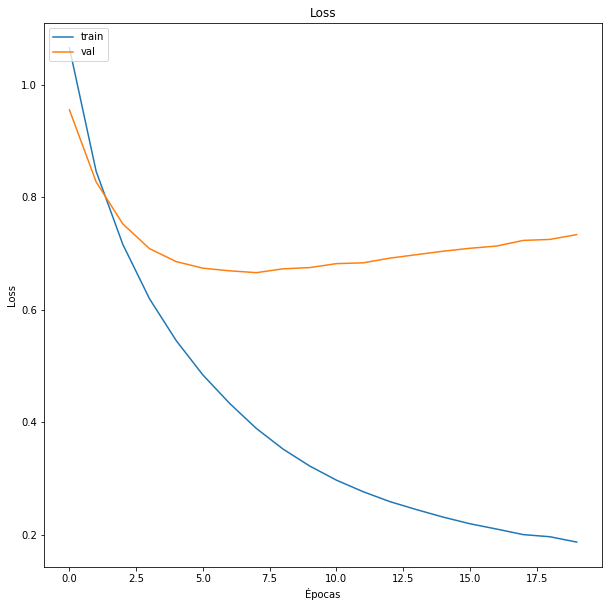

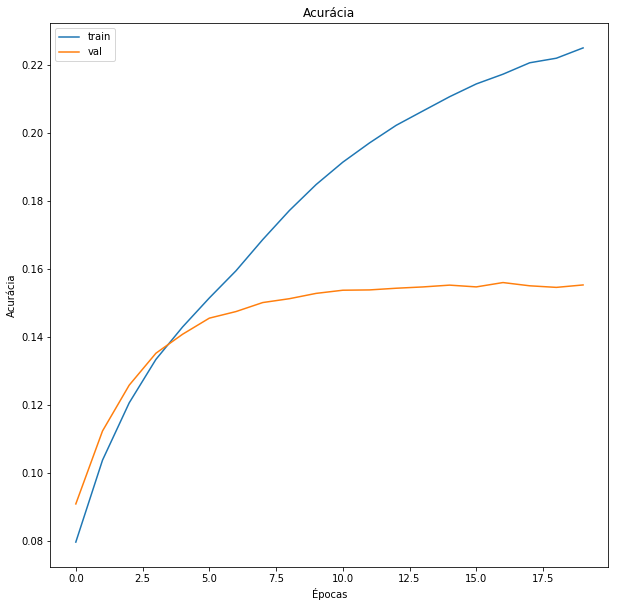

In [140]:
def plot_loss(history):
    plt.figure(figsize=(10, 10))
    plt.title('Loss')
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.ylabel('Loss')
    plt.xlabel('Épocas')
    plt.legend(loc=2)
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(10, 10))
    plt.title('Acurácia')
    plt.plot(history['train_acc'], label='train')
    plt.plot(history['val_acc'], label='val')
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.legend(loc=2)
    plt.show()

plot_loss(history)
plot_accuracy(history)

In [141]:
# recupera o ultimo modelo LSTM salvo (com a maior acuracia)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

def evaluate(sentence):
    attention_plot = np.zeros((MAXTOKENS_SL, MAXTOKENS_NL))
    #sentence = data_prep.preprocess_sentence(sentence)
    inputs = input_tokenizer_model.predict([sentence])
    n_sentences = len(inputs)
    inputs = Concatenate(axis=0)([inputs, tf.zeros((BATCH_SIZE - n_sentences, MAXTOKENS_NL), dtype=tf.dtypes.int64)])
    #print(inputs.shape)
    result = ''
    hidden = encoder.initialize_hidden_state()
    enc_output, enc_forward_h, enc_forward_c, enc_backward_h, enc_backward_c = encoder(inputs, hidden)
    dec_hidden = Concatenate(axis=1)([enc_forward_h, enc_backward_h])
    dec_input = tf.expand_dims([word_index['[INI-SL]']] * BATCH_SIZE, 1)
    result += '[INI-SL]' + ' '
    for t in range(MAXTOKENS_SL):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_output)
        #print(predictions)
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights[0], (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += tokenizer_vocab[predicted_id] + ' '
        if tokenizer_vocab[predicted_id] == '[END-SL]':
            return result, sentence, attention_plot
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id] * BATCH_SIZE, 1)
        #print(dec_input.shape)
    return result, sentence, attention_plot


In [143]:
x = "[INI-NL] redwood is a census designated place in jefferson county , new york , united states . as of the 2010 census , the area population was 605 . [END-NL]"
structured_language, natural_language, att = evaluate(x)
print("Input: \n{}\n\n".format(natural_language))
print("Output: \n{}\n\n".format(structured_language))


Input: 
[INI-NL] redwood is a census designated place in jefferson county , new york , united states . as of the 2010 census , the area population was 605 . [END-NL]


Output: 
[INI-SL] InstanceOf census designated place [SEP] LocatedInTheAdministrativeTerritorialEntity pierce county [SEP] Country united states [END-SL] 


